This notebook demonstrates data slicing for the National Renewable Energy Laboratory (NREL) National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS). These slicing methods would also work with the WIND Toolkit data available via HSDS at /nrel/wtk/

For this to work you must first install h5pyd:

```
pip install --user h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

You can also add the above contents to a configuration file at ~/.hscfg

This example will also be using NREL's Renewable Energy Potential (V) model [`NREL-reV`](https://github.com/nrel/reV) which can be installed with pip:
```
pip install NREL-reV
```
or with conda:
```
conda install nrel-rev
```

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
%matplotlib inline
sns.set_style("white")

from reV.generation.generation import Gen
from rex import Resource
from rex.utilities import init_logger

cwd = os.getcwd()
bin_dir = os.path.join(os.path.dirname(cwd), 'bin')

/home/mrossol/miniconda3/envs/rev-hsds/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
init_logger('reV', log_level='DEBUG')

<Logger reV (DEBUG)>

In [4]:
from pyinstrument import Profiler

profiler = Profiler()
profiler.start()

nsrdb_file = '/datasets/NSRDB/v3/nsrdb_2013.h5'
config_path = os.path.join(bin_dir, 'pv_SAM_config.json')
pv_gen = Gen.reV_run(tech='pvwattsv7', points=list(range(100)),
                     sam_files=config_path,
                     res_file=nsrdb_file, max_workers=1, fout=None,
                     output_request=('cf_mean', 'cf_profile'))

profiler.stop()

print(profiler.output_text(unicode=True, color=True))

profiler.open_in_browser()

DEBUG - 2020-06-03 16:40:42,513 [generation.py:979] : Sites per worker being set to 372 based on chunk size of /datasets/NSRDB/v3/nsrdb_2013.h5.
DEBUG - 2020-06-03 16:40:42,513 [generation.py:888] : Sites per worker being set to 372 for Gen/Econ PointsControl.
INFO - 2020-06-03 16:40:47,439 [generation.py:627] : Output results from a single site are calculated to use 0.0 KB of memory.
INFO - 2020-06-03 16:40:47,439 [generation.py:596] : Generation limited to storing 1137388 sites in memory (99.6 GB total hardware, 39.9 GB available with 40.0% utilization).
INFO - 2020-06-03 16:40:47,440 [generation.py:535] : Initializing in-memory outputs for 100 sites with gids 0 through 99 inclusive (site list index 0 through 99)
INFO - 2020-06-03 16:40:47,442 [version_checker.py:50] : reV is using PySAM version 2.1.3
INFO - 2020-06-03 16:40:47,443 [generation.py:1457] : Running reV generation for: PointsControl for sites 0 through 99
DEBUG - 2020-06-03 16:40:47,443 [generation.py:1459] : The followi

'/tmp/tmpz44ohjre.html'

## Solar Generation
Extract meta data and find site "gids" associated with Boulder, Colorado

In [2]:
nsrdb_file = '/nrel/nsrdb/v3/nsrdb_2013.h5'
with Resource(nsrdb_file, hsds=True) as f:
    nsrdb_meta = f.meta
    nsrdb_ti = f.time_index
    print(f.get_dset_properties('dhi'))
    
nsrdb_meta.head()

((17520, 2018392), dtype('int16'), (2688, 372))


latitude   longitude  elevation  timezone country state county urban  \
0    -19.99 -175.259995        0.0        13    None  None   None  None   
1    -19.99 -175.220001        0.0        13    None  None   None  None   
2    -19.99 -175.179993        0.0        13    None  None   None  None   
3    -19.99 -175.139999        0.0        13    None  None   None  None   
4    -19.99 -175.100006        0.0        13    None  None   None  None   

   population  landcover  
0       -9999        210  
1       -9999        210  
2       -9999        210  
3       -9999        210  
4       -9999        210

In [3]:
state = 'Colorado'
nsrdb_points = nsrdb_meta['state'] == state
nsrdb_points = nsrdb_meta.index[nsrdb_points].tolist()
nsrdb_points_meta = nsrdb_meta.loc[nsrdb_points[::10]]
print('Number of NSRDB points in {}: {}'.format(state, len(nsrdb_points)))

Number of NSRDB points in Colorado: 17500


Run reV Gen for every 10th site in Colorado, USA

In [16]:
# SAM configuration for wind turbine
config_path = os.path.join(bin_dir, 'pv_SAM_config.json')
with open(config_path, 'r') as f:
    SAM_config = json.load(f)
    
SAM_config

{'adjust:constant': 0,
 'array_type': 2,
 'azimuth': 180,
 'capital_cost': 39767200,
 'dc_ac_ratio': 1.3,
 'fixed_charge_rate': 0.096,
 'fixed_operating_cost': 260000,
 'gcr': 0.4,
 'inv_eff': 96,
 'losses': 14.07566,
 'module_type': 0,
 'system_capacity': 20000,
 'tilt': 0,
 'variable_operating_cost': 0}

In [3]:
nsrdb_file = '/datasets/NSRDB/v3/nsrdb_2013.h5'

In [6]:
from rex import NSRDB

In [7]:

%time res_data = NSRDB.preload_SAM(nsrdb_file, list(range(1750)))

CPU times: user 32.7 s, sys: 1.72 s, total: 34.4 s
Wall time: 6.59 s


In [10]:
dir(res_data)

['CSP_DATA_RANGES',
 'DATA_RANGES',
 'LF_DATA_RANGES',
 'PV_DATA_RANGES',
 'RES_VARS',
 'SWH_DATA_RANGES',
 'TPPH_DATA_RANGES',
 'WIND_DATA_RANGES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_physical_ranges',
 '_get_res_df',
 '_get_var_mean',
 '_get_var_ts',
 '_h',
 '_i',
 '_mean_arrays',
 '_meta',
 '_n',
 '_parse_sites',
 '_res_arrays',
 '_runnable',
 '_set_var_array',
 '_shape',
 '_sites',
 '_tech',
 '_time_index',
 '_var_list',
 'append_var_list',
 'check_units',
 'curtail_windspeed',
 'enforce_arr_range',
 'h',
 'meta',
 'runnable',
 'set_clearsky',
 'shape',
 'sites',
 'sites_slice

In [19]:
# Run reV Gen in series locally
ts = time.time()
pv_gen = Gen.reV_run(tech='pvwattsv7', points=nsrdb_points[::10], 
                     sites_per_worker=len(nsrdb_points[::10]),
                     sam_files=config_path,
                     res_file=nsrdb_file, max_workers=1, fout=None,
                     output_request=('cf_mean', 'cf_profile'))

tt = time.time() - ts
print('Time to compute generation for {} sites = {:.4f} min'
      .format(len(nsrdb_points[::10]), tt / 60))

DEBUG - 2020-06-03 16:06:48,258 [generation.py:888] : Sites per worker being set to 1 for Gen/Econ PointsControl.


DEBUG:reV.generation.generation:Sites per worker being set to 1 for Gen/Econ PointsControl.


INFO - 2020-06-03 16:06:52,207 [generation.py:627] : Output results from a single site are calculated to use 0.0 KB of memory.


INFO:reV.generation.generation:Output results from a single site are calculated to use 0.0 KB of memory.


INFO - 2020-06-03 16:06:52,208 [generation.py:596] : Generation limited to storing 1137388 sites in memory (99.6 GB total hardware, 39.9 GB available with 40.0% utilization).


INFO:reV.generation.generation:Generation limited to storing 1137388 sites in memory (99.6 GB total hardware, 39.9 GB available with 40.0% utilization).


INFO - 2020-06-03 16:06:52,209 [generation.py:535] : Initializing in-memory outputs for 1750 sites with gids 0 through 1749 inclusive (site list index 0 through 1749)


INFO:reV.generation.generation:Initializing in-memory outputs for 1750 sites with gids 0 through 1749 inclusive (site list index 0 through 1749)


INFO - 2020-06-03 16:06:52,211 [version_checker.py:50] : reV is using PySAM version 2.1.3


INFO:reV.SAM.version_checker:reV is using PySAM version 2.1.3


INFO - 2020-06-03 16:06:52,279 [generation.py:1457] : Running reV generation for: PointsControl for sites 0 through 1749


INFO:reV.generation.generation:Running reV generation for: PointsControl for sites 0 through 1749


DEBUG - 2020-06-03 16:06:52,280 [generation.py:1459] : The following project points were specified: "[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201

DEBUG:reV.generation.generation:The following project points were specified: "[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 2

DEBUG - 2020-06-03 16:06:52,281 [generation.py:1461] : The following SAM configs are available to this run:
'/home/mrossol/hsds-examples/bin/pv_SAM_config.json'


DEBUG:reV.generation.generation:The following SAM configs are available to this run:
'/home/mrossol/hsds-examples/bin/pv_SAM_config.json'


DEBUG - 2020-06-03 16:06:52,281 [generation.py:1463] : The SAM output variables have been requested:
('cf_mean', 'cf_profile')


DEBUG:reV.generation.generation:The SAM output variables have been requested:
('cf_mean', 'cf_profile')


DEBUG - 2020-06-03 16:06:52,282 [generation.py:1468] : Running serial generation for: PointsControl for sites 0 through 1749


DEBUG:reV.generation.generation:Running serial generation for: PointsControl for sites 0 through 1749


DEBUG - 2020-06-03 16:06:52,282 [project_points.py:48] : PointsControl iterator initializing with sites 0 through 1749


DEBUG:reV.config.project_points:PointsControl iterator initializing with sites 0 through 1749


DEBUG - 2020-06-03 16:06:52,977 [project_points.py:66] : PointsControl stopped iteration at attempted index of 1750. Length of iterator is: 1750


DEBUG:reV.config.project_points:PointsControl stopped iteration at attempted index of 1750. Length of iterator is: 1750


DEBUG - 2020-06-03 16:06:52,977 [project_points.py:88] : PointsControl passing site project points with indices 0 to 1 on iteration #0 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 0 to 1 on iteration #0 


DEBUG - 2020-06-03 16:06:55,026 [project_points.py:88] : PointsControl passing site project points with indices 1 to 2 on iteration #1 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 1 to 2 on iteration #1 


DEBUG - 2020-06-03 16:06:57,065 [project_points.py:88] : PointsControl passing site project points with indices 2 to 3 on iteration #2 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 2 to 3 on iteration #2 


DEBUG - 2020-06-03 16:06:59,101 [project_points.py:88] : PointsControl passing site project points with indices 3 to 4 on iteration #3 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 3 to 4 on iteration #3 


DEBUG - 2020-06-03 16:07:01,135 [project_points.py:88] : PointsControl passing site project points with indices 4 to 5 on iteration #4 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 4 to 5 on iteration #4 


DEBUG - 2020-06-03 16:07:03,170 [project_points.py:88] : PointsControl passing site project points with indices 5 to 6 on iteration #5 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 5 to 6 on iteration #5 


DEBUG - 2020-06-03 16:07:05,204 [project_points.py:88] : PointsControl passing site project points with indices 6 to 7 on iteration #6 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 6 to 7 on iteration #6 


DEBUG - 2020-06-03 16:07:07,237 [project_points.py:88] : PointsControl passing site project points with indices 7 to 8 on iteration #7 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 7 to 8 on iteration #7 


DEBUG - 2020-06-03 16:07:09,268 [project_points.py:88] : PointsControl passing site project points with indices 8 to 9 on iteration #8 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 8 to 9 on iteration #8 


DEBUG - 2020-06-03 16:07:11,300 [project_points.py:88] : PointsControl passing site project points with indices 9 to 10 on iteration #9 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 9 to 10 on iteration #9 


DEBUG - 2020-06-03 16:07:13,324 [project_points.py:88] : PointsControl passing site project points with indices 10 to 11 on iteration #10 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 10 to 11 on iteration #10 


DEBUG - 2020-06-03 16:07:15,355 [project_points.py:88] : PointsControl passing site project points with indices 11 to 12 on iteration #11 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 11 to 12 on iteration #11 


DEBUG - 2020-06-03 16:07:17,385 [project_points.py:88] : PointsControl passing site project points with indices 12 to 13 on iteration #12 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 12 to 13 on iteration #12 


DEBUG - 2020-06-03 16:07:19,418 [project_points.py:88] : PointsControl passing site project points with indices 13 to 14 on iteration #13 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 13 to 14 on iteration #13 


DEBUG - 2020-06-03 16:07:21,441 [project_points.py:88] : PointsControl passing site project points with indices 14 to 15 on iteration #14 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 14 to 15 on iteration #14 


DEBUG - 2020-06-03 16:07:23,472 [project_points.py:88] : PointsControl passing site project points with indices 15 to 16 on iteration #15 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 15 to 16 on iteration #15 


DEBUG - 2020-06-03 16:07:25,504 [project_points.py:88] : PointsControl passing site project points with indices 16 to 17 on iteration #16 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 16 to 17 on iteration #16 


DEBUG - 2020-06-03 16:07:27,536 [project_points.py:88] : PointsControl passing site project points with indices 17 to 18 on iteration #17 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 17 to 18 on iteration #17 


DEBUG - 2020-06-03 16:07:29,568 [project_points.py:88] : PointsControl passing site project points with indices 18 to 19 on iteration #18 


DEBUG:reV.config.project_points:PointsControl passing site project points with indices 18 to 19 on iteration #18 


KeyboardInterrupt: 

/home/mrossol/miniconda3/envs/rev-hsds/lib/python3.7/site-packages/seaborn/utils.py:279: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


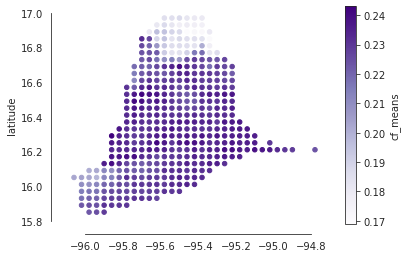

In [6]:
# Extract CF means
cf_means = nsrdb_points_meta[['latitude', 'longitude']].copy()
cf_means['cf_means'] = pv_gen.out['cf_mean'] / 1000

cf_means.plot.scatter(x='longitude', y='latitude', c='cf_means', cmap='Purples')
sns.despine(offset=10, trim=True)
plt.show()

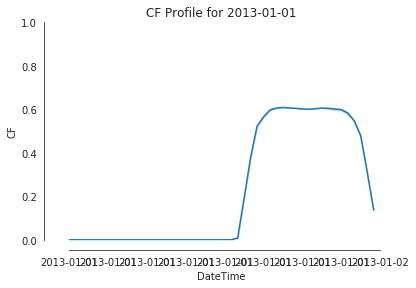

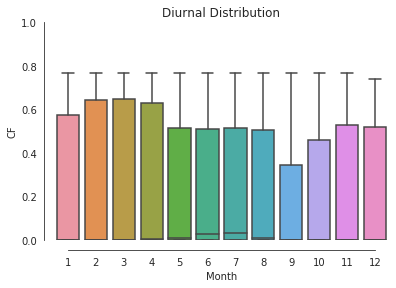

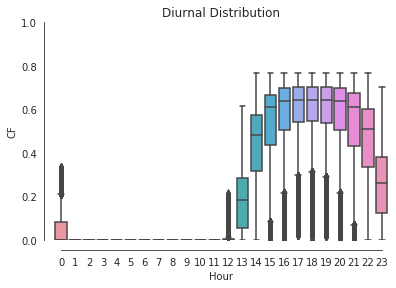

In [7]:
# Extract CF profiles
cf_profiles = pd.DataFrame(pv_gen.out['cf_profile'] / 1000, columns=points)
cf_profiles['DateTime'] = nsrdb_ti
cf_profiles['Month'] = nsrdb_ti.month
cf_profiles['Hour'] = nsrdb_ti.hour

sns_profiles = pd.melt(cf_profiles, id_vars=['DateTime', 'Month', 'Hour'],
                       value_name='CF')
sns_profiles.index = pd.to_datetime(sns_profiles['DateTime'])

mask = sns_profiles.index < pd.to_datetime('2013-01-02')
ax = sns.lineplot(x="DateTime", y="CF",
             markers=True, dashes=False, data=sns_profiles.loc[mask])
plt.title('CF Profile for 2013-01-01')
ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()


ax = sns.boxplot(x="Month", y="CF", data=sns_profiles)
plt.title('Diurnal Distribution')

ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()


ax = sns.boxplot(x="Hour", y="CF", data=sns_profiles)
plt.title('Diurnal Distribution')
ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()

### Wind Generation
Extract meta data and find site "gids" associated with Dist. Tehuantepec, Oaxaca

In [16]:
wind_file = '/nrel/wtk/conus/wtk_conus_2013.h5'
with Resource(wind_file, hsds=True) as f:
    wind_meta = f.meta
    wind_ti = f.time_index
    print(f.get_dset_properties('dhi'))
    
wind_meta.head()

latitude   longitude country state county  timezone  elevation  offshore
0  37.603382 -127.617050    None  None   None        -9          0         1
1  37.620419 -127.626007    None  None   None        -9          0         1
2  37.637451 -127.634979    None  None   None        -9          0         1
3  37.654484 -127.643951    None  None   None        -9          0         1
4  37.671509 -127.652924    None  None   None        -9          0         1

In [24]:
state = 'Colorado'
wind_points = wind_meta['state'] == state
wind_points = wind_meta.index[wind_points].tolist()
wind_points_meta = wind_meta.loc[wind_points[::10]]
print('Number of wind points in {}: {}'.format(state, len(wind_points)))

Number of WTK points in Colorado: 63678


Run reV Gen for every 100th point in Colorado, USA

In [27]:
# SAM configuration for wind turbine
config_path = os.path.join(bin_dir, 'wind_SAM_config.json')
with open(config_path, 'r') as f:
    SAM_config = json.load(f)
    
SAM_config

{'adjust:constant': 0,
 'system_capacity': 1620,
 'wind_farm_losses_percent': 16.7,
 'wind_farm_wake_model': 0,
 'wind_farm_xCoordinates': [0],
 'wind_farm_yCoordinates': [0],
 'wind_resource_model_choice': 0,
 'wind_resource_shear': 0.140000001,
 'wind_resource_turbulence_coeff': 0.1,
 'wind_turbine_hub_ht': 80,
 'wind_turbine_powercurve_powerout': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  9,
  16,
  49,
  81,
  122,
  163,
  211,
  259,
  319,
  378,
  441,
  504,
  574,
  643,
  726,
  808,
  896,
  984,
  1072,
  1159,
  1236,
  1312,
  1369,
  1426,
  1473,
  1519,
  1545,
  1571,
  1583,
  1594,
  1602,
  1609,
  1614,
  1619,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,

In [29]:
# Run reV Gen in series locally
ts = time.time()
wind_gen = Gen.reV_run(tech='windpower', points=wind_points[::100], sam_files=config_path,
                  res_file=wind_file, max_workers=1, fout=None,
                  output_request=('cf_mean', 'cf_profile'))

tt = time.time() - ts
print('Time to compute generation for {} sites = {:.4f} min'
      .format(len(wind_points), tt / 60))

KeyboardInterrupt: 

/home/mrossol/miniconda3/envs/rev-hsds/lib/python3.7/site-packages/seaborn/utils.py:279: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


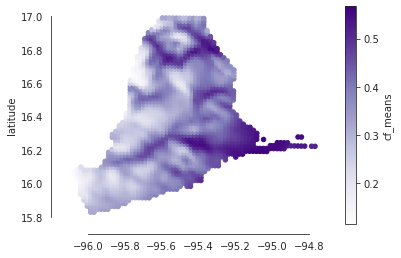

In [12]:
# Extract CF means
cf_means = wind_points_meta[['latitude', 'longitude']].copy()
cf_means['cf_means'] = wind_gen.out['cf_mean'] / 1000

cf_means.plot.scatter(x='longitude', y='latitude', c='cf_means', cmap='Purples')
sns.despine(offset=10, trim=True)
plt.show()

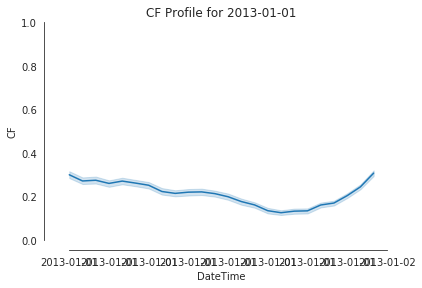

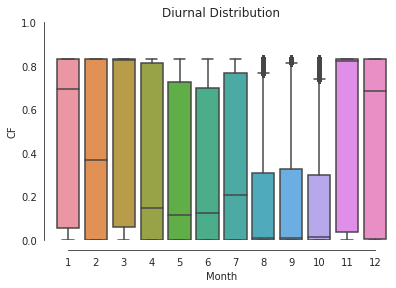

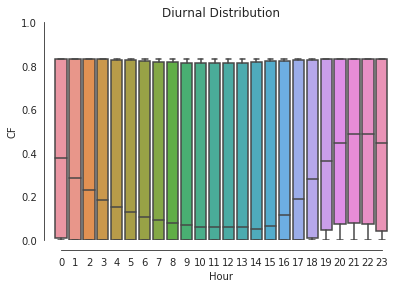

In [13]:
# Extract CF profiles
cf_profiles = pd.DataFrame(wind_gen.out['cf_profile'] / 1000, columns=points)
cf_profiles['DateTime'] = wind_ti
cf_profiles['Month'] = wind_ti.month
cf_profiles['Hour'] = wind_ti.hour

sns_profiles = pd.melt(cf_profiles, id_vars=['DateTime', 'Month', 'Hour'],
                       value_name='CF')
sns_profiles.index = pd.to_datetime(sns_profiles['DateTime'])

mask = sns_profiles.index < pd.to_datetime('2013-01-02')
ax = sns.lineplot(x="DateTime", y="CF",
             markers=True, dashes=False, data=sns_profiles.loc[mask])
plt.title('CF Profile for 2013-01-01')
ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()


ax = sns.boxplot(x="Month", y="CF", data=sns_profiles)
plt.title('Diurnal Distribution')

ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()


ax = sns.boxplot(x="Hour", y="CF", data=sns_profiles)
plt.title('Diurnal Distribution')
ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()